In [264]:
import numpy as np
norm = np.linalg.norm
sqrt = np.math.sqrt
dot = np.dot
array = np.array
from scipy.spatial.transform import Rotation
import pandas as pd
import os

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from multiprocessing.pool import ThreadPool

In [2]:
class Segmentation:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
        if "theta" in kwargs:
            self.set_angle(kwargs["theta"])
        else:
            raise ValueError("Diffraction angle missing.")
            
    def set_angle(self, angle, degrees=True):
        self.theta = angle
        self.rot_mat = Rotation.from_euler("z", 180-2*angle, degrees=degrees).as_matrix()[:2,:2]
    
    def rotate(self, array, angle=None):
        if angle is None:
            angle = self.theta
        return np.matmul(array, seg.rot_mat)
    
    def gen_coords(self, dtype=np.float64):
        b = self.r_cell*(1+self.margin)
        X = np.linspace(-b, b, self.resolution[0], dtype=np.float64)
        return array(np.meshgrid(X, X, indexing="ij"), dtype=np.float64).swapaxes(0,2)

    
    def intersectER(self, x, radius, right=True):
        return array([(-1)**int(not right)*sqrt(radius**2 - x[1]**2), x[1]])

    def dist_F1(self, x):
        """
        REN = ray entry point
        REX = ray exit point
        
        (case A_{s,sc})
        """

        # 1
        d_cell, d_sample = 0.0, 0.0
        # 2
        if norm(x) <= self.r_sample:
            REN_g1o = self.intersectER(x, self.r_cell, right=0)
            REN_g1i = self.intersectER(x, self.r_sample, right=0)
            
            d_sample = norm(x - REN_g1i)
            d_cell = norm(REN_g1i - REN_g1o)

        return d_cell, d_sample

    def dist_F2(self, x): 
        """(case A_{c,sc})"""
        
        # 1
        d_cell, d_sample = 0.0, 0.0
        # 2
        if self.r_sample < norm(x) <= self.r_cell:
            REN_g1o = self.intersectER(x, self.r_cell, right=0)
            
            if (x[0] >= 0 and abs(x[1]) < self.r_sample): # right of sample and ER intersection
                REN_g1i = self.intersectER(x, self.r_sample, right=0)
                REX_g1i = self.intersectER(x, self.r_sample)
                d_cell = norm(REN_g1o - REN_g1i) + norm(REX_g1i - x)
                d_sample = norm(REN_g1i - REX_g1i)

            else: # left of sample or no ER sample intersection
                d_cell = norm(REN_g1o - x)
                
        return d_cell, d_sample
    
    def dist(self, x):
        """
        Computes travel distance of ray through medium with diffraction point in x
        """
        return array([
            self.dist_F1(x),
            self.dist_F2(x),
            self.dist_F2(x)
        ])
    
    
    def get_g1_dists(self, coords=None):
        if coords is None:
            coords = self.gen_coords()
        g1_dists = np.apply_along_axis(self.dist, 2, coords)
        g1_dists[:,:,2,1] = 0.0
        return g1_dists
    
    def get_g2_dists(self, coords=None):
        if coords is None:
            coords = self.gen_coords()
            
        coords_rotated = self.rotate(coords)
        return self.get_g1_dists(coords=coords_rotated)
            
    def get_dists(self, coords=None, g1_dists=None):
        if g1_dists is None:
            g1_dists = self.get_g1_dists(coords=coords)
        g2_dists = self.get_g2_dists(coords=coords)
        return g1_dists + g2_dists

    def plot_dists(self, cmap=None, distances=None):
        if distances is None:
            distances = self.get_dists()
        
        titles = ["Cell", "Sample", "Total"]
        fig, axes = plt.subplots(ncols=distances.shape[2], figsize=(16,10), gridspec_kw={'width_ratios': [1]*distances.shape[2]})
        for i in range(distances.shape[2]):
            im = axes[i].imshow(distances[:,:,i], 
                        cmap=cmap, interpolation='none', 
                        origin="lower",
                        extent=[-self.r_cell*(1+self.margin), self.r_cell*(1+margin)]*2,
                        vmin=distances.min(), vmax=distances.max()
                    )
            axes[i].set_title(titles[i] + " distances")
        
        if cmap is None:
            cmp = plt.cm.get_cmap("viridis", 10)
        cmp.set_bad(color='red')
        cmp.set_under(color="black")
        fig.colorbar(im, ax=axes, orientation='horizontal', fraction=.1, aspect=30, pad=0.1)
        return axes
    

    def get_absorptionfactor(self, distances, mu):
        """Input dim"""
        case_mask = [[1,1], [1,1], [1,0]]
        absorptions = np.exp((-distances * case_mask * self.mu).sum(axis=3))
        if "debug" in self.__dict__ and self.debug:
            print(absorptions.shape)
            print(absorptions[absorptions!=1].shape)
        return np.array([
            np.sum(absorptions[:,:,0][absorptions[:,:,0]!=1])/absorptions[absorptions[:,:,0]!=1].shape[0],
            np.sum(absorptions[:,:,1][absorptions[:,:,1]!=1])/absorptions[absorptions[:,:,1]!=1].shape[0],
            np.sum(absorptions[:,:,2][absorptions[:,:,2]!=1])/absorptions[absorptions[:,:,2]!=1].shape[0]
        ]
        )
        # TODO: fix this shit
    
    def step_angle(self, angles, coords=None, g1_dists=None, pbar=None):
        factors = np.zeros(shape=(len(angles), len(cases)))
        if coords is None:
            coords = self.gen_coords()
        if g1_dists is None:
            g1_dists = self.get_g1_dists(coords=coords)
        
        for i in range(len(angles)):
            self.set_angle(angles[i])
            distances = g1_dists + self.get_g2_dists(coords=coords)
            factors[i,:] = self.get_absorptionfactor(distances, self.mu)
            pbar.update(1)
        return factors
    
    def get_absorptionfactors(self, angles=np.linspace(1.0,90,5), pbar=None):
        if pbar is None:
            pbar = tqdm(total=angles.size)
        coords = self.gen_coords()
        angle_absorptions = self.step_angle(angles, coords=coords, pbar=pbar)
        return angle_absorptions
    
    def save_absorptionfactors(self, absorptions, path, angles, float_format="%.3f"):
        df = pd.DataFrame(absorptions, index=angles, columns=["A_{s,sc}", "A_{c,sc}", "A_{c,c}"])
        df.index.name = "2 theta"
        df.index = df.index.map(lambda x: float_format % x)
        df.to_csv(path)
    
    def plot_absorbfactors(self, angles=np.linspace(1.0,90,5), figsize=(18,4), pbar=None):
        angle_absorptions = self.get_absorptionfactors(angles, pbar=pbar)

        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True)
        st = fig.suptitle(f"Absorptions for angles [{angles.min()},...,{angles.max()}]", fontsize=14)
        st.set_y(1.04)

        case_strings = ["A_{s,sc}", "A_{c,sc}", "A_{c,c}"]
        colors = ["violet", "orange", "red"]
        for i in range(3):
            axs[i].plot(angles, angle_absorptions[:,i], color=colors[i])
            axs[i].set_title(f"{case_strings[i]}")

        return fig,axs 

In [308]:
scale_det = 2**1

config = {
    "seg" : {
        "debug" : False,
        "theta" : 0.0,
        "r_cell" : 1.2,
        "r_sample" : 1.0,
        "mu" : array([.54747*1E-1, 6.70333*1E-1]),  # cell, sample.
        "margin" : 0.05,
        "resolution" : array([1, 1])*2**11
    },
    "det" : {
        "shape" : (array([1, 1])*2**11 / scale_det).astype(int), # pixel count on each axis.
        "distance" : 240.18,    # [mm] distance from centerpoint x_0 of medium to projection point p_0 on detector plane.
        "offsets" : scale_det*array([4.6, 4.3, 0.0]), # [mm,mm,mm] offsets from p_0 to origin point on detector plane. Origin=lower right.
        "pixelsize" : scale_det*array([200*1E-3, 200*1E-3]) # [mm,mm] size of each pixel on detector.
    }
}
#config["det"]["offsets"] = config["det"]["shape"]/2 * config["det"]["pixelsize"]
config["seg"]["resolution"] = (config["seg"]["resolution"]/2**5).astype(int)
config["seg"]["resolution"] = array([1,1])*151

In [309]:
config["det"]["shape"]

array([1024, 1024])

In [310]:
config["seg"]["resolution"]

array([151, 151])

In [311]:
config["det"]["pixelsize"]*config["det"]["shape"]

array([409.6, 409.6])

In [191]:
class Detector:
    """
    Detector is on XY-plane, with z=0. 
    Every segment point has distance
    """
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
        self.plane_det = self.gen_coords()
        self.precompute_trig()
    
    def gen_coords(self):
        X = np.linspace(self.pixelsize[0]*self.shape[0], 0, self.shape[0], dtype=np.float64)
        Y = np.linspace(self.pixelsize[1]*self.shape[1], 0, self.shape[1], dtype=np.float64)
        plane_coords = array(np.meshgrid(X, Y, indexing="ij"), dtype=np.float64).swapaxes(0,2)
        return np.insert(plane_coords, 2, 0, axis=2)
    
    def translate_segments(self, segment_coords):
        """
        Translate segment 2D space into detector 3D space.
        """
        # Put segment coordinates from segment space axes X,Y on detector space axes Z,X:
        plane_seg = np.zeros(array(segment_coords.shape)+[0,0,1]) # expand segment space to 3D
        plane_seg[:,:,0] = segment_coords[:,:,1] + self.offsets[0]       # axis swap Y -> X. Add X-offset.
        plane_seg[:,:,1] = self.offsets[1]                               # add Y-offset.
        plane_seg[:,:,2] = segment_coords[:,:,0] + self.distance         # axis swap X -> Z. Add detector distance.
        return plane_seg

    # obsolete ?
    def translate_segments_inv(self, det_coords):
        return det_coords - array([self.offsets[0], self.offsets[1], self.distance])
    
    def projection(self, segment_plane):
        """Project coordinates of segment onto plane. (intersection point of g1 and plane)"""
        return segment_plane*[1,1,0]
        
    def project_Y(self):
        """Project detector coordinates onto XZ-plane."""
        return self.plane_det*[1,0,1]#+[0,self.offsets[1],0]
    
    def precompute_trig(self):
        # angles_theta on X-axis, repeat on Y-axis.
        # (b) distances on XZ-plane, repeat on Y-axis
        # (c) distances on YZ-plane, repeat  on X-axis.
        
        #self.plane_dists_h = self.distance/
        #self.thetas = 
        
        self.trig = np.zeros(self.plane_det.shape)     # array with vectors (theta, b_dist, c_dist)
        self.trig[:,:,1] = norm(self.project_Y() - array([self.offsets[0], 0, self.distance]), axis=2)
        self.trig[:,:,0] = np.apply_along_axis(np.arccos, 0, self.distance/self.trig[:,:,1])*180/np.pi/2
        self.trig[:,:,2] = norm(self.plane_det - array([self.offsets[0], self.offsets[1], self.distance]), axis=2)
        self.trig = self.trig.swapaxes(0,1)
    
    def absorptionfactors_3D(self, i, coords, pbar_inner=None):
        """
        Calculate absorption factors for each vertical angle (alpha) and one horizontal angle (theta), i.e. 
        one column of the detector.
        OUTPUT SHAPE: (Y resolution, 3)
        """
        # TODO: make sure that self.seg exists.
        # calculate g2_dists once, translate into 3D detector space.
        theta = np.abs(self.trig[i,0,0])
        self.seg.set_angle(theta)
        g2_dists = self.seg.get_g2_dists(coords=coords)
        
        if "g1_dists" not in self.__dict__.keys():
            raise ValueError("Precompute g1_dists first")
        
        # for each point on detector, (where theta and alpha are given by position):
        #   calculate b/c = cos(alpha).
        #   expand 2D g2_dists to 3D g2_dists by stretching g2_dist with cos(alpha).
        #   calculate absorption factor.
        cosines = np.abs(self.trig[i,0,1]/self.trig[i,:,2])
        column = np.zeros((cosines.shape[0], 3)) # (2048,3)
        for j in range(cosines.shape[0]):
            if pbar_inner is not None and (j % 16)==0:
                pbar_inner.set_description(
                    f"(theta, alpha) = ({self.seg.theta:1.4f}, {np.arccos(np.abs(cosines[j]))/2*180/np.pi:1.4f})"
                )
            total_dists = self.g1_dists + g2_dists/cosines[j]
            #total_dists = self.g1_dists + self.get_g2_dists_3D(i,j, coords, self.seg)
            tmp = self.seg.get_absorptionfactor(total_dists, seg.mu) # (3,)
            column[j] = tmp
            if pbar_inner is not None:
                pbar_inner.update(1)
        return column
    
    def travel_dists(self, seg):
        """
        Calculate absorption factor columns for all thetas.
        OUTPUT SHAPE: (X resolution, Y resolution, 3)
        """
        # Precompute segment coordinates and g1_dists.
        self.seg = seg
        self.segment_coords = self.seg.gen_coords()
        self.g1_dists = self.seg.get_g1_dists()
        
        # For each column step (2theta step) on detector, calculate column of absorption factors for all alphas.
        absorptionfactors = np.zeros(self.plane_det.shape) # (2048,2048,3)
        try:
            pbar_outer = tqdm(total=self.plane_det.shape[0], desc="Iterating over detector row (theta angles).")
            pbar_inner = tqdm(total=self.plane_det.shape[1], desc="Iterating over detector column (alpha angles).")
            for i in range(self.plane_det.shape[0]):
                pbar_inner.reset()
                pbar_outer.set_description(f"theta={self.trig[i,0,0]:1.4f}:")
                pbar_outer.refresh()
                absorptionfactors[i,:,:] = self.absorptionfactors_3D(
                    i=i, 
                    coords=self.segment_coords,
                    pbar_inner=pbar_inner
                ) # (2048,3)
                pbar_outer.update(1)
        except KeyboardInterrupt:
            pbar_outer.close()
            pbar_inner.close()
        finally:
            pbar_outer.close()
            pbar_inner.close()
        
        return absorptionfactors

In [313]:
seg = Segmentation(**config["seg"])
det = Detector(
    **config["det"]
    #**{k:v for k,v in config["det"].items() if k!= "offsets"}, offsets=array([120,150])
)

In [ ]:
absf = det.travel_dists(seg)

In [295]:
np.save(f"data/factors_2D (py, res={absf.shape[0]}, offset=[4.6,4.3])", absf)

In [306]:
def plot_absorptions(factors, aspect=1.0, origin="lower", cmap=None, extent=None):
    if cmap is None:
        cmap = plt.cm.viridis;
    
    titles = ["A_s,sc", "A_c,sc", "A_c,c"]
    fig, axes = plt.subplots(ncols=factors.shape[2], figsize=(16,10), gridspec_kw={'width_ratios': [1]*factors.shape[2]})
    for case in range(absf.shape[2]):
        im = axes[case].imshow(
            factors[:,:,case],
            cmap=cmap, 
            interpolation='none',
            extent=extent,
            origin=origin
        )
        divider = make_axes_locatable(axes[case])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)
        axes[case].set_title(titles[case], pad=8)
    plt.subplots_adjust(wspace=0.4)
        
    return fig, axes

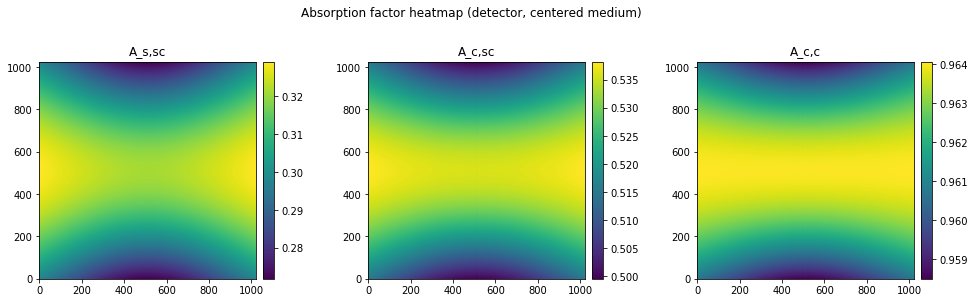

In [307]:
fig, axes = plot_absorptions(absf.swapaxes(0,1))
st = fig.suptitle("Absorption factor heatmap (detector, centered medium)");
st.set_y(0.73)

In [190]:
absf[64,64,0]

0.3209809968146551

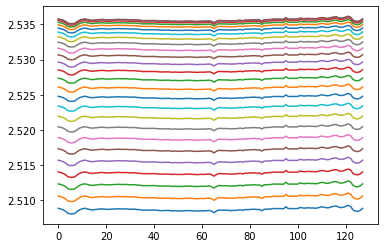

In [256]:
for j in list(range(absf.shape[1]))[::5]:
    plt.plot(absf[:,j,1])

<div style="height:2cm">

In [176]:
coords = seg.gen_coords(-seg.r_cell*1.05, seg.r_cell*1.05, 512)

In [12]:
def array_info(arr):
    return array([
        ["Min", arr.min(axis=(0,1))],
        ["Max", arr.max(axis=(0,1))],
    ])

In [33]:
segment_plane = det.translate_segments(det.plane_det)

In [22]:
array_info(segment_plane)

array([['Min', array([  4.6 ,   4.3 , 240.18])],
       ['Max', array([107.  ,   4.3 , 342.58])]], dtype=object)

In [1128]:
(segment_plane - det.offsets)[:,:,2].max()

ValueError: operands could not be broadcast together with shapes (512,512,4) (3,) 

<IPython.core.display.Javascript object>


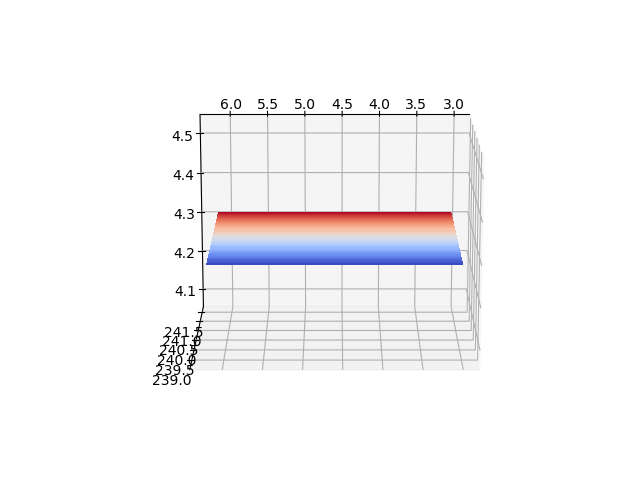

In [1024]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(
    segment_plane[:,:,0], 
    segment_plane[:,:,1],
    #np.ones(segment_plane.shape)[:,:,0],
    segment_plane[:,:,2]+norm(segment_plane[:,:,:2], axis=2), 
    cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)

ax.view_init(-75, 90)
plt.draw()

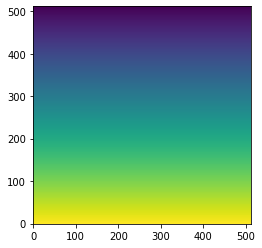

In [899]:
plt.imshow(det.plane_coords[:,:,1], origin="lower")

In [910]:
pl = det.plane_coords

In [962]:
len(pl[pl[:,:,1]<det.offsets[1]])/pl.size

0.014322916666666666